In [335]:
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [336]:
diagnostics = False

### General information and assumptions

In [345]:
print('Wavenumber spectrum: 0 to 3000 cm^-1')
print('Wavelength spectrum: {0:.1e} to {1:.1e} m'.format(converter(3000, 'wavenumber', 'wavelength'), converter(1, 'wavenumber', 'wavelength')))

Wavenumber spectrum: 0 to 3000 cm^-1
Wavelength spectrum: 3.3e-06 to 1.0e-02 m


### Assignment responses

#### Pre-project, Problem 1

##### Pre-project, Problem 1a, CIRC2

In [348]:
flux_circ2_all = main(atmosphere='CIRC2', gas=None, bands='all')
print('CIRC2 flux: {0:.2f} W m^-2 | Stefan-Boltzmann flux: {1:.2f} W m^-2 | Error: {2:.2f} %'.format(flux_circ2_all, sb(307.74), 100*(flux_circ2_all-sb(307.74))/sb(307.74)))
del flux_circ2_all 

CIRC2 flux: 508.82 W m^-2 | Stefan-Boltzmann flux: 508.53 W m^-2 | Error: 0.06 %


##### Pre-project, Problem 1b, CIRC4

In [349]:
flux_circ4_all = main(atmosphere='CIRC4', gas=None, bands='all')
print('CIRC4 flux: {0:.2f} W m^-2 | Stefan-Boltzmann flux: {1:.2f} W m^-2 | Error: {2:.2f} %'.format(flux_circ4_all, sb(266.55), 100*(flux_circ4_all-sb(266.65))/sb(266.65)))
del flux_circ4_all

CIRC4 flux: 286.63 W m^-2 | Stefan-Boltzmann flux: 286.22 W m^-2 | Error: -0.01 %


#### Pre-project, Problem 2

##### Pre-project, Problem 2a, CIRC2

In [350]:
for band in range(1, 15):
    flux_circ2_all_baseline = main(atmosphere='CIRC2', gas=None, bands=band)
    flux_circ2_all_dT = main(atmosphere='CIRC2', gas=None, bands=band, dT=1)
    flux_circ2_abs_diff = flux_circ2_all_dT - flux_circ2_all_baseline
    flux_circ2_pct_diff = 100*(flux_circ2_all_dT - flux_circ2_all_baseline)/flux_circ2_all_baseline
    print('Band {0:2d} | Baseline flux: {1:6.2f} W m^-2 | dT+1 flux: {2:6.2f} W m^-2 | Abs. diff.: {3:6.2f} W m^-2 | % diff.: {4:6.2f} %'.format(band, flux_circ2_all_baseline, flux_circ2_all_dT, flux_circ2_abs_diff, flux_circ2_pct_diff))
    
del flux_circ2_all_baseline, flux_circ2_all_dT, flux_circ2_abs_diff, flux_circ2_pct_diff

Band  1 | Baseline flux:   8.82 W m^-2 | dT+1 flux:   8.85 W m^-2 | Abs. diff.:   0.04 W m^-2 | % diff.:   0.43 %
Band  2 | Baseline flux: 149.35 W m^-2 | dT+1 flux: 150.42 W m^-2 | Abs. diff.:   1.07 W m^-2 | % diff.:   0.72 %
Band  3 | Baseline flux:  36.37 W m^-2 | dT+1 flux:  36.73 W m^-2 | Abs. diff.:   0.35 W m^-2 | % diff.:   0.97 %
Band  4 | Baseline flux:  35.95 W m^-2 | dT+1 flux:  36.33 W m^-2 | Abs. diff.:   0.38 W m^-2 | % diff.:   1.06 %
Band  5 | Baseline flux:  48.74 W m^-2 | dT+1 flux:  49.31 W m^-2 | Abs. diff.:   0.57 W m^-2 | % diff.:   1.18 %
Band  6 | Baseline flux:  43.97 W m^-2 | dT+1 flux:  44.55 W m^-2 | Abs. diff.:   0.58 W m^-2 | % diff.:   1.32 %
Band  7 | Baseline flux:  34.66 W m^-2 | dT+1 flux:  35.16 W m^-2 | Abs. diff.:   0.51 W m^-2 | % diff.:   1.46 %
Band  8 | Baseline flux:  26.71 W m^-2 | dT+1 flux:  27.13 W m^-2 | Abs. diff.:   0.42 W m^-2 | % diff.:   1.58 %
Band  9 | Baseline flux:  35.47 W m^-2 | dT+1 flux:  36.08 W m^-2 | Abs. diff.:   0.62 W

##### Pre-project, Problem 2b, CIRC4

In [351]:
for band in range(1, 15):
    flux_circ4_all_baseline = main(atmosphere='CIRC4', gas=None, bands=band)
    flux_circ4_all_dT = main(atmosphere='CIRC4', gas=None, bands=band, dT=1)
    flux_circ4_abs_diff = flux_circ4_all_dT - flux_circ4_all_baseline
    flux_circ4_pct_diff = 100*(flux_circ4_all_dT - flux_circ4_all_baseline)/flux_circ4_all_baseline
    print('Band {0:2d} | Baseline flux: {1:6.2f} W m^-2 | dT+1 flux: {2:6.2f} W m^-2 | Abs. diff.: {3:6.2f} W m^-2 | % diff.: {4:6.2f} %'.format(band, flux_circ4_all_baseline, flux_circ4_all_dT, flux_circ4_abs_diff, flux_circ4_pct_diff))
    
del flux_circ4_all_baseline, flux_circ4_all_dT, flux_circ4_abs_diff, flux_circ4_pct_diff

Band  1 | Baseline flux:   7.27 W m^-2 | dT+1 flux:   7.30 W m^-2 | Abs. diff.:   0.04 W m^-2 | % diff.:   0.51 %
Band  2 | Baseline flux: 107.20 W m^-2 | dT+1 flux: 108.17 W m^-2 | Abs. diff.:   0.97 W m^-2 | % diff.:   0.91 %
Band  3 | Baseline flux:  23.13 W m^-2 | dT+1 flux:  23.42 W m^-2 | Abs. diff.:   0.29 W m^-2 | % diff.:   1.26 %
Band  4 | Baseline flux:  21.85 W m^-2 | dT+1 flux:  22.15 W m^-2 | Abs. diff.:   0.30 W m^-2 | % diff.:   1.39 %
Band  5 | Baseline flux:  28.00 W m^-2 | dT+1 flux:  28.43 W m^-2 | Abs. diff.:   0.43 W m^-2 | % diff.:   1.55 %
Band  6 | Baseline flux:  23.60 W m^-2 | dT+1 flux:  24.01 W m^-2 | Abs. diff.:   0.41 W m^-2 | % diff.:   1.75 %
Band  7 | Baseline flux:  17.41 W m^-2 | dT+1 flux:  17.75 W m^-2 | Abs. diff.:   0.34 W m^-2 | % diff.:   1.93 %
Band  8 | Baseline flux:  12.64 W m^-2 | dT+1 flux:  12.91 W m^-2 | Abs. diff.:   0.27 W m^-2 | % diff.:   2.11 %
Band  9 | Baseline flux:  15.61 W m^-2 | dT+1 flux:  15.97 W m^-2 | Abs. diff.:   0.36 W

### Project

#### Problem 1

Magnitudes may be accurate (see Pavlakis et al., 2004; Zhang et al. 10.1029/94JD027471, Lecture 6/7, Slide 28 from David Paynter)

In [354]:
# List gases of interest
gases = ['CO2', 'H2OCTM', 'CH4', 'N2O', 'O3', 'ALLGAS']
# List atmospheres of interest
atms = ['CIRC2', 'CIRC4']

for atm in atms:
    for gas in gases:
        f_toa, f_sfc = flux_layered(atmosphere=atm, gas_name=gas, bands='all', z='toa'), flux_layered(atmosphere=atm, gas_name=gas, bands='all', z='sfc')
        print('Atmospheric profile: {0} | Gas: {1:6} | Flux at TOA: {2:6.2f} W m^-2 | Flux at surface: {3:6.2f} W m^-2'.format(atm, gas, f_toa, f_sfc))
        
del gases, gas, atms, atm, f_toa, f_sfc

Atmospheric profile: CIRC2 | Gas: CO2    | Flux at TOA: 138.53 W m^-2 | Flux at surface:  74.63 W m^-2
Atmospheric profile: CIRC2 | Gas: H2OCTM | Flux at TOA: 742.62 W m^-2 | Flux at surface: 380.78 W m^-2
Atmospheric profile: CIRC2 | Gas: CH4    | Flux at TOA:  14.64 W m^-2 | Flux at surface:   6.64 W m^-2
Atmospheric profile: CIRC2 | Gas: N2O    | Flux at TOA:  18.76 W m^-2 | Flux at surface:   7.90 W m^-2
Atmospheric profile: CIRC2 | Gas: O3     | Flux at TOA:  25.59 W m^-2 | Flux at surface:   7.15 W m^-2
Atmospheric profile: CIRC2 | Gas: ALLGAS | Flux at TOA: 722.12 W m^-2 | Flux at surface: 391.38 W m^-2
Atmospheric profile: CIRC4 | Gas: CO2    | Flux at TOA:  89.66 W m^-2 | Flux at surface:  48.65 W m^-2
Atmospheric profile: CIRC4 | Gas: H2OCTM | Flux at TOA: 280.69 W m^-2 | Flux at surface: 143.93 W m^-2
Atmospheric profile: CIRC4 | Gas: CH4    | Flux at TOA:   6.66 W m^-2 | Flux at surface:   3.53 W m^-2
Atmospheric profile: CIRC4 | Gas: N2O    | Flux at TOA:   9.57 W m^-2 | F

#### Problem 2

H2O continuum alone

In [355]:
# List gases of interest
gases = ['H2OCTM']
# List atmospheres of interest
atms = ['CIRC2', 'CIRC4']
# List of bands of interest
bands = range(1, 15)

for atm in atms:
    for gas in gases:
        for band in bands:
            f_toa, f_sfc = flux_layered(atmosphere=atm, gas_name=gas, bands=band, z='toa'), flux_layered(atmosphere=atm, gas_name=gas, bands=band, z='sfc')
            print('Atmospheric profile: {0} | Gas: {1:6} | Band: {2:3} | Flux at TOA: {3:6.2f} W m^-2 | Flux at surface: {4:6.2f} W m^-2'.format(atm, gas, band, f_toa, f_sfc))
        
del bands, gases, gas, atms, atm, f_toa, f_sfc

Atmospheric profile: CIRC2 | Gas: H2OCTM | Band:   1 | Flux at TOA:  30.99 W m^-2 | Flux at surface:  18.38 W m^-2
Atmospheric profile: CIRC2 | Gas: H2OCTM | Band:   2 | Flux at TOA: 237.02 W m^-2 | Flux at surface: 138.08 W m^-2
Atmospheric profile: CIRC2 | Gas: H2OCTM | Band:   3 | Flux at TOA:  60.89 W m^-2 | Flux at surface:  25.16 W m^-2
Atmospheric profile: CIRC2 | Gas: H2OCTM | Band:   4 | Flux at TOA:  61.14 W m^-2 | Flux at surface:  25.85 W m^-2
Atmospheric profile: CIRC2 | Gas: H2OCTM | Band:   5 | Flux at TOA:  80.59 W m^-2 | Flux at surface:  35.21 W m^-2
Atmospheric profile: CIRC2 | Gas: H2OCTM | Band:   6 | Flux at TOA:  62.10 W m^-2 | Flux at surface:  27.32 W m^-2
Atmospheric profile: CIRC2 | Gas: H2OCTM | Band:   7 | Flux at TOA:  39.54 W m^-2 | Flux at surface:  17.36 W m^-2
Atmospheric profile: CIRC2 | Gas: H2OCTM | Band:   8 | Flux at TOA:  25.72 W m^-2 | Flux at surface:  11.20 W m^-2
Atmospheric profile: CIRC2 | Gas: H2OCTM | Band:   9 | Flux at TOA:  36.21 W m^-

#### Problem 3

##### Problem 3a

2xCO2 alone

In [356]:
# List gases of interest
gases = ['2xCO2']
# List atmospheres of interest
atms = ['CIRC2', 'CIRC4']
# List of bands of interest
bands = range(1, 15)

for atm in atms:
    for gas in gases:
        for band in bands:
            f_toa, f_sfc = flux_layered(atmosphere=atm, gas_name=gas, bands=band, z='toa'), flux_layered(atmosphere=atm, gas_name=gas, bands=band, z='sfc')
            print('Atmospheric profile: {0} | Gas: {1:6} | Band: {2:3} | Flux at TOA: {3:6.2f} W m^-2 | Flux at surface: {4:6.2f} W m^-2'.format(atm, gas, band, f_toa, f_sfc))
        
del bands, gases, gas, atms, atm, f_toa, f_sfc

Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   1 | Flux at TOA:   0.00 W m^-2 | Flux at surface:   0.00 W m^-2
Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   2 | Flux at TOA:   2.12 W m^-2 | Flux at surface:   0.95 W m^-2
Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   3 | Flux at TOA:  42.28 W m^-2 | Flux at surface:  20.61 W m^-2
Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   4 | Flux at TOA:  46.90 W m^-2 | Flux at surface:  33.20 W m^-2
Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   5 | Flux at TOA:  45.76 W m^-2 | Flux at surface:  23.11 W m^-2
Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   6 | Flux at TOA:   1.51 W m^-2 | Flux at surface:   0.63 W m^-2
Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   7 | Flux at TOA:   3.89 W m^-2 | Flux at surface:   1.63 W m^-2
Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   8 | Flux at TOA:   2.79 W m^-2 | Flux at surface:   1.17 W m^-2
Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   9 | Flux at TOA:   1.65 W m^-

##### Problem 3b
_Generate data files for the 2xCO2 cases._

In [359]:
atm_profiles = ['CIRC2', 'CIRC4']
levels = ['SFC', 'TOA']

for atm_profile in atm_profiles:
    for level in levels:
        
        baseline = load(atmosphere=atm_profile, gas_name='ALLGAS')
        baseline_2xco2 = baseline.copy().loc[baseline['level'] == level].set_index('layer_pres')
        
        co2 = load(atmosphere=atm_profile, gas_name='CO2')
        co2 = co2.loc[co2['level'] == level].set_index('layer_pres').iloc[:, 2:-3]
        co2x2 = load(atmosphere=atm_profile, gas_name='2xCO2')
        co2x2 = co2x2.loc[co2x2['level'] == level].set_index('layer_pres').iloc[:, 2:-3]
        
        # Divide out the CO2 transmittances
        baseline_2xco2.iloc[:, 2:-3] = baseline_2xco2.iloc[:, 2:-3]*co2x2/co2
        baseline_2xco2 = baseline_2xco2.reset_index()
        fname = 'data/{0}_LAYER_ALLGAS2XCO2_{1}.csv'.format(atm_profile, level)
        baseline_2xco2.where(baseline_2xco2['level'] == level).dropna().to_csv(fname, index=False);
        
del atm_profiles, levels, baseline, baseline_2xco2, co2, co2x2, fname

All gases, except CO2 is now 2xCO2. To get 2xCO2's effect on fluxes, double the CO2 concentration in the 'ALLGAS' case. To do so, divide the CO2 transmittances from the 'ALLGAS' case and multiply by the 2xCO2 transmittances.

In [362]:
# List gases of interest
gases = ['2xCO2', 'H2OCTM', 'CH4', 'N2O', 'O3', 'ALLGAS2XCO2']
# List atmospheres of interest
atms = ['CIRC2', 'CIRC4']
# List of bands of interest
bands = range(1, 15)

for atm in atms:
    for gas in gases:
        f_toa, f_sfc = flux_layered(atmosphere=atm, gas_name=gas, bands='all', z='toa'), flux_layered(atmosphere=atm, gas_name=gas, bands='all', z='sfc')
        print('Atmospheric profile: {0} | Gas: {1:11} | Flux at TOA: {2:6.2f} W m^-2 | Flux at surface: {3:6.2f} W m^-2'.format(atm, gas, f_toa, f_sfc))
             
del gases, gas, atms, atm, f_toa, f_sfc

Atmospheric profile: CIRC2 | Gas: 2xCO2       | Flux at TOA: 152.47 W m^-2 | Flux at surface:  84.84 W m^-2
Atmospheric profile: CIRC2 | Gas: H2OCTM      | Flux at TOA: 742.62 W m^-2 | Flux at surface: 380.78 W m^-2
Atmospheric profile: CIRC2 | Gas: CH4         | Flux at TOA:  14.64 W m^-2 | Flux at surface:   6.64 W m^-2
Atmospheric profile: CIRC2 | Gas: N2O         | Flux at TOA:  18.76 W m^-2 | Flux at surface:   7.90 W m^-2
Atmospheric profile: CIRC2 | Gas: O3          | Flux at TOA:  25.59 W m^-2 | Flux at surface:   7.15 W m^-2
Atmospheric profile: CIRC2 | Gas: ALLGAS2XCO2 | Flux at TOA: 721.07 W m^-2 | Flux at surface: 395.19 W m^-2
Atmospheric profile: CIRC4 | Gas: 2xCO2       | Flux at TOA:  98.04 W m^-2 | Flux at surface:  53.62 W m^-2
Atmospheric profile: CIRC4 | Gas: H2OCTM      | Flux at TOA: 280.69 W m^-2 | Flux at surface: 143.93 W m^-2
Atmospheric profile: CIRC4 | Gas: CH4         | Flux at TOA:   6.66 W m^-2 | Flux at surface:   3.53 W m^-2
Atmospheric profile: CIRC4 |

##### Problem 3c

All gases, except CO2 is now 2xCO2, and H2OCTM is now H2O.

In [364]:
# List gases of interest
gases = ['2xCO2', 'H2O', 'CH4', 'N2O', 'O3', 'ALLGAS2XCO2']
# List atmospheres of interest
atms = ['CIRC2', 'CIRC4']
# List of bands of interest
bands = range(1, 15)

for atm in atms:
    for gas in gases:
        f_toa, f_sfc = flux_layered(atmosphere=atm, gas_name=gas, bands='all', z='toa'), flux_layered(atmosphere=atm, gas_name=gas, bands='all', z='sfc')
        print('Atmospheric profile: {0} | Gas: {1:6} | Flux at TOA: {2:6.2f} W m^-2 | Flux at surface: {3:6.2f} W m^-2'.format(atm, gas, f_toa, f_sfc))
             
del bands, gases, gas, atms, atm, f_toa, f_sfc

Atmospheric profile: CIRC2 | Gas: 2xCO2  | Flux at TOA: 152.47 W m^-2 | Flux at surface:  84.84 W m^-2
Atmospheric profile: CIRC2 | Gas: H2O    | Flux at TOA: 576.00 W m^-2 | Flux at surface: 305.36 W m^-2
Atmospheric profile: CIRC2 | Gas: CH4    | Flux at TOA:  14.64 W m^-2 | Flux at surface:   6.64 W m^-2
Atmospheric profile: CIRC2 | Gas: N2O    | Flux at TOA:  18.76 W m^-2 | Flux at surface:   7.90 W m^-2
Atmospheric profile: CIRC2 | Gas: O3     | Flux at TOA:  25.59 W m^-2 | Flux at surface:   7.15 W m^-2
Atmospheric profile: CIRC2 | Gas: ALLGAS2XCO2 | Flux at TOA: 721.07 W m^-2 | Flux at surface: 395.19 W m^-2
Atmospheric profile: CIRC4 | Gas: 2xCO2  | Flux at TOA:  98.04 W m^-2 | Flux at surface:  53.62 W m^-2
Atmospheric profile: CIRC4 | Gas: H2O    | Flux at TOA: 263.16 W m^-2 | Flux at surface: 135.23 W m^-2
Atmospheric profile: CIRC4 | Gas: CH4    | Flux at TOA:   6.66 W m^-2 | Flux at surface:   3.53 W m^-2
Atmospheric profile: CIRC4 | Gas: N2O    | Flux at TOA:   9.57 W m^-

#### Problem 4

##### Generate temperatures in a global warming case

266.2300109863


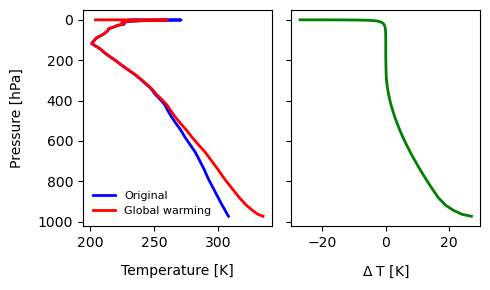

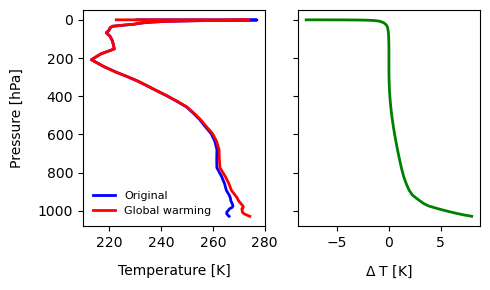

In [447]:
# Generate temperatures from any gas data for each atmosphere (all profiles are the same at SFC and TOA)
sample_circ2 = load(atmosphere='CIRC2')
sample_circ2 = sample_circ2.loc[sample_circ2['level'] == 'SFC']
sample_circ4 = load(atmosphere='CIRC4')
sample_circ4 = sample_circ4.loc[sample_circ4['level'] == 'SFC']

print(sample_circ4['layer_temp'].values[0])

T_gw_circ2 = temp_change(sample_circ2, 3)
T_gw_circ4 = temp_change(sample_circ4, 2)

# Plot the differences
plot_temp(sample_circ2, T_gw_circ2)
plt.gca()
plot_temp(sample_circ4, T_gw_circ4)

### Main function

In [347]:
def main(atmosphere='CIRC2', gas=None, bands='all', dT=0):
    
    if atmosphere.lower() == 'circ2':
        T_s = 307.74 + dT
    elif atmosphere.lower() == 'circ4':
        T_s = 266.55 + dT
    
    if bands == 'all':
        bands = range(1, 15)
    elif type(bands) is not list:
        bands = [bands]
    
    F_total = 0
    
    for band in bands[::-1]:
        if diagnostics:
            print('Band {0}'.format(band))
        band_data = band_info(band=band)
        wavelengths = [1/band_data['min'], 1/band_data['max']]

        F = flux(T_s, wavelengths)
        F_total += F
        
    return F_total

### Auxiliary functions

#### Flux in a layered atmosphere

Reference Lecture 3, Slide 19 from David Paynter

In [338]:
def flux_layered(atmosphere='CIRC2', gas_name='ALLGAS', bands='all', z='sfc'):
    
    transmittance_data = load(atmosphere=atmosphere, gas_name=gas_name)
    
    if bands == 'all':
        bands = range(1, 15)
    elif type(bands) is not list:
        bands = [bands]
    
    # Initialize flux as 0
    F = 0
    
    # Iterate over each band
    for band in bands:
        # Get data for iterand band
        band_data = band_info(band=band)
        # Get wavelength bounds for the band
        wavelengths = [1/band_data['min'], 1/band_data['max']]

        ''' Handle TOA fluxes. '''
        # Term 1: Surface flux (intensity at surface * transmittance over depth of atmosphere)
        # Term 2: Atmospheric layer fluxes (intensity at layer * transmittance over layer)
        # Term 3: TOA fluxes (intensity at TOA * transmittance at TOA)
        if z.lower() == 'toa':
            # Get transmittance data at TOA
            transmittance_data = transmittance_data.loc[transmittance_data['level'] == z.upper()]
            # print(transmittance_data)
            # Get surface and TOA temperatures. This assumes that DataFrame is sorted by ascending height
            T_s, T_toa = transmittance_data.iloc[0]['layer_temp'], transmittance_data.iloc[-1]['layer_temp']
            # print(T_s, T_toa)
            
            # Calculate first term in equation for F_{TOA} from Slide 19 of David Paynter's Lecture 3
            term_1 = flux(T_s, wavelengths, N=100)*(transmittance_data.iloc[-1]['tb_{0}'.format(band)] - transmittance_data.iloc[0]['tb_{0}'.format(band)])

            # Initialize term 2 flux (summation term from equation for F_{TOA} from Slide 19 of David Paynter's Lecture 3)
            term_2 = 0
            # Summation from top to bottom level, descending in height
            for i in range(len(transmittance_data['layer_pres'])-1, 1, -1):
                term_2_T = transmittance_data.iloc[i-1]['layer_temp']
                term_2_F = flux(term_2_T, wavelengths, N=100)*(transmittance_data.iloc[i]['tb_{0}'.format(band)] - transmittance_data.iloc[i-1]['tb_{0}'.format(band)])
                term_2 += term_2_F

            # Calculate third term in equation for F_{TOA} from Slide 19 of David Paynter's Lecture 3
            term_3 = flux(T_toa, wavelengths, N=100)*(1 - transmittance_data.iloc[-1]['tb_{0}'.format(band)])

            F += term_1 + term_2 + term_3
    
        ''' Handle surface fluxes. '''
        # Term 1: Surface flux (intensity at surface * transmittance over depth of atmosphere)
        # Term 2: Atmospheric layer fluxes (intensity at layer * transmittance over layer)
        # Term 3: TOA fluxes (intensity at TOA * transmittance at TOA)
        if z.lower() == 'sfc':
            # Get transmittance data at surface
            transmittance_data = transmittance_data.loc[transmittance_data['level'] == z.upper()]
            # Get surface and TOA temperatures. This assumes that DataFrame is sorted by ascending height
            T_s, T_toa = transmittance_data.iloc[0]['layer_temp'], transmittance_data.iloc[-1]['layer_temp']

            # Initialize term 1 flux (summation term from equation for F_{SFC} from Slide 19 of David Paynter's Lecture 3)
            term_1 = 0
            # Summation from bottom to top level, ascending in height
            for i in range(1, len(transmittance_data['layer_pres'])-1):
                term_1_T = transmittance_data.iloc[i+1]['layer_temp']
                term_1_F = flux(term_1_T, wavelengths, N=100)*(transmittance_data.iloc[i]['tb_{0}'.format(band)] - transmittance_data.iloc[i+1]['tb_{0}'.format(band)])
                term_1 += term_1_F
                
            # Calculate second term in equation for F_{SFC} from Slide 19 of David Paynter's Lecture 3
            term_2 = flux(T_s, wavelengths, N=100)*(1 - transmittance_data.iloc[0]['tb_{0}'.format(band)])

            F += term_1 + term_2
    
    return F

#### Flux discretization function
Integrates flux for a temperature over a given range of wavelengths using the trapezoidal method over $N$ intervals.

In [339]:
def flux(T, wavelengths, N=500):
    # Get wavelength limits for the band
    wavelength_max, wavelength_min = wavelengths
    # Override fluxes for the last interval (lowest wavenumber, largest wavelength)
    if wavelength_max == np.inf:
        wavelength_max = 1e-2
        
    if diagnostics:
        print('\t Wavelength min.: {0:8.2e} m, Wavelength max.: {1:8.2e} m,'.format(wavelength_min, wavelength_max))
    
    # Discretize band into N subintervals
    intervals = np.linspace(wavelength_min, wavelength_max, N)
    # Initialize flux value
    F = 0
    # Calculate fluxes over all band subintervals
    for i in range(0, len(intervals)-1):
        F_ = (np.pi/2)*(B_wavelength(T, intervals[i]) + B_wavelength(T, intervals[i+1]))*(intervals[i+1] - intervals[i])
        F += F_
        if diagnostics:
            print('\t \t Interval min.: {0:8.2e} m, Interval max.: {1:8.2e} m, Interval flux: {2:8.2e} W m^-2'.format(intervals[i], intervals[i+1], F_)) 
    
    return F

#### Intensity source function
Calculates the radiation intensity $B_{\lambda}$ for a given temperature and wavelength.

Reference: Goody & Yung (1995), Eq. 2.38

In [340]:
def B_wavelength(T, wavelength):
    
    # Speed of light {c} (m s^-1)
    c = 3e8
    # Planck constant {h} (m^2 kg s^-1)
    h = 6.626e-34
    # Boltzmann constant {k} (m^2 kg s^-2 K^-1)
    k = 1.381e-23
    # Calculate radiation constants per Goody, Eqs. 2.39 and 2.40
    C1 = 2*np.pi*h*c**2
    C2 = h*c/k
    # Calculate intensity per Goody, Eq. 2.38
    B = C1/(wavelength**(5) * np.pi * (np.exp(C2/(wavelength*T)) - 1))
    
    return B

#### Stefan-Boltzmann flux (ideal blackbody radiation)

In [341]:
def sb(T):
    return 5.67e-8 * T**4

#### Band data constructor
Generates Pandas DataFrame with band wavenumber data for accessing.

In [342]:
def band_info(band=None):
    # Define headers
    header = ['band', 'min', 'max']
    # Import data and set index to be band number
    bands = pd.read_csv('data/bands_info.csv', names=header).set_index('band')
    # Adjust units from cm^-1 to m^-1
    bands = bands*100
    # Calculate mean across each band
    bands['mean'] = bands.mean(axis=1)

    if band == 'all':
        return bands
    else:
        return bands.iloc[band-1]

#### Gas transmittance data constructor
Generates Pandas DataFrame with gas transmittances from surface to TOA for each gas for each atmosphere.

In [343]:
def load(atmosphere='CIRC2', gas_name='ALLGAS'):
    ''' Method to load line-by-line transmittance data.
    
    Inputs:
        - gas_name: Name of the gas for which data will be loaded. Default is 'ALLGAS'.
        - atmosphere: Name of the CIRC profile data will be loaded for.
    Outputs:
        - gas_data: Pandas Dataframe with data for the selected gas.
        
    '''

    # Define folder name where data files are stored
    dirname = 'data'
    # Get all paths for files where data that meets criteria is stored
    files = [os.path.join(dirname, file) for file in os.listdir(dirname) if (file.split('/')[-1].split('_')[-2] == gas_name) and (atmosphere in file)]
    # Define column header names (see project description document)
    header = ['tb_{0}'.format(i-1) for i in range(2, 14+2)]
    header.insert(0, 'layer_pres')
    header.insert(0, 'layer_temp')
    # Initialize output Dataframe
    gas_data = []
    # Fill Dataframe iteratively (iteration used to construct auxiliary data columns)
    for file in files:
        # Load data
        if file.split('.')[-1] == 'txt':
            tmp = pd.read_csv(file, sep='\s+', names=header)
        elif file.split('.')[-1] == 'csv':
            tmp = pd.read_csv(file, sep=',')
        # Add column with atmospheric profile of data
        tmp['atm_profile'] = file.split('/')[-1].split('_')[0]
        # Add column with gas name
        tmp['gas'] = file.split('/')[-1].split('_')[-2]
        # Add column with level
        tmp['level'] = file.split('.')[0].split('_')[-1]
        # Append to list
        gas_data.append(tmp)
    # Concatenate Dataframes
    gas_data = pd.concat(gas_data).reset_index(drop=True)
    
    return gas_data

In [344]:
def converter(input_value=None, input_type=None, output_type=None):
    
    # Takes and returns frequency and wavelengths in SI units (mKs), wavenumber in cm^-1
    
    output_value = None
    c = 3e8 # m
    
    if output_type == 'wavenumber':
        if input_type == 'frequency':
            frequency = input_value
            wavelength = c/frequency
            output_value = 1/wavelength/100
        elif input_type == 'wavelength':
            wavelength = input_value
            output_value = 1/wavelength/100
            
    elif output_type == 'wavelength':
        if input_type == 'frequency':
            frequency = input_value
            output_value = c/frequency
        elif input_type == 'wavenumber':
            wavenumber = input_value
            output_value = 1/wavenumber/100
            
    elif output_type == 'frequency':
        if input_type == 'wavelength':
            wavelength = input_value
            output_value = c/wavelength
        elif input_type == 'wavenumber':
            wavenumber = input_value
            wavelength = 100/wavenumber
            output_value = c/wavelength
            
    return output_value

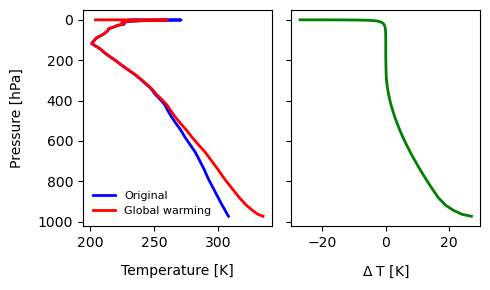

In [435]:
test = load()
test = test.loc[test['level'] == 'SFC']
t2 = temp_change(test.layer_temp, 3)
plot_temp(test, t2)

del test, test

In [446]:
def temp_change(T, alpha):
    return [T['layer_temp'].values[i] - n**3 for i, n in enumerate(np.linspace(-alpha, alpha, len(T)))]

In [448]:
def plot_temp(baseline, warmed):
    fig, ax = plt.subplots(figsize=(5, 3), ncols=2, sharey=True)
    
    orig = ax[0].plot(baseline['layer_temp'], baseline['layer_pres'], c='b', lw=2, label='Original')
    new = ax[0].plot(warmed, baseline['layer_pres'], c='r', ls='--', lw=2, label='Global warming')
    diff = ax[1].plot(warmed-baseline['layer_temp'], baseline['layer_pres'], c='g', lw=2)
    
    labelpad = 10
    ax[0].set_xlabel('Temperature [K]', labelpad=labelpad)    
    ax[1].set_xlabel('$\Delta$ T [K]', labelpad=labelpad)
    ax[0].set_ylabel('Pressure [hPa]', labelpad=labelpad)
    
    ax[0].set_ylim(ax[0].get_ylim()[::-1])
    fig.tight_layout()
    ax[0].legend(loc='lower left', ncols=1, frameon=False, fontsize=8)